# 4-7. 프로젝트: CutMix 또는 Mixup 비교실험 하기

지금까지 기본적인 augmentation 방법을 적용해서 모델을 훈련시키고, 최신 augmentation 기법 (CutMix, Mixup) 을 배워 보았습니다.

이번에는 최신 기법(CutMix, Mixup)을 적용해 모델을 훈련시켜보고,

원본 이미지, 기본 augmentation, CutMix, Mixup augmentation 을 적용한 모델 성능을 비교해보는 프로젝트를 진행해 보도록 하겠습니다.

### 목차
---
#### 1. Augmentation을 적용한 데이터셋 만들기
#### 2. 모델 만들기
#### 3. 모델 훈련하기
#### 4. 훈련 과정 시각화하기
#### 5. Augmentation에 의한 모델 성능 비교
#### 6. 루브릭 & 회고 & Reference

## 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

Q1. 아래는 CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset()입니다. batch() 함수 뒤에 CutMix가 오도록 만들어야합니다. 그 이유가 뭘까요?

A1. CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 합니다.

### 1-1. 필요한 라이브러리 import
---
Augmentation도 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 이미지 데이터 전처리 방법과 활용방법이 동일합니다.

먼저 필요한 라이브러리들을 불러와 주도록 하겠습니다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# 학습 전에는 항상 GPU 환경을 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1-2. 데이터 불러오기
---
이번 프로젝트에서는 `stanford_dogs` 데이터셋을 사용해서 진행해 보도록 하겠습니다.

`stanford_dogs` 데이터셋

- 120개 견종의 이미지가 포함되어 있습니다.

- 총 20,580장의 이미지에서 12,000장은 학습셋이고 나머지 8,580장은 평가용 데이터셋으로 구성되어 있습니다.

In [3]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

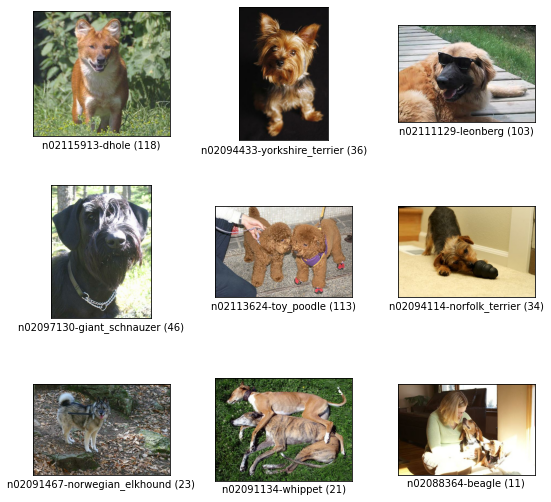

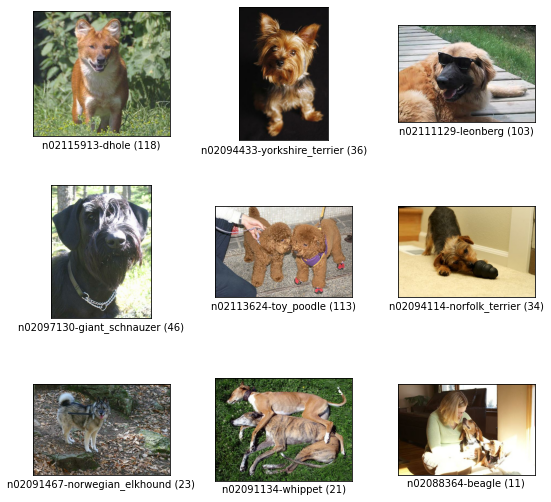

In [4]:
# train 데이터셋 내 이미지 생성
tfds.show_examples(ds_train, ds_info)

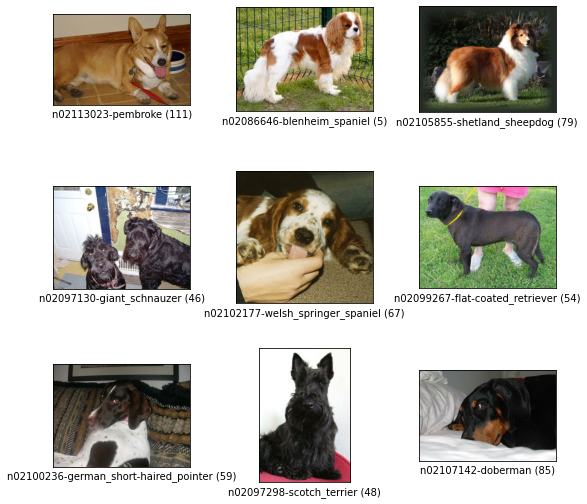

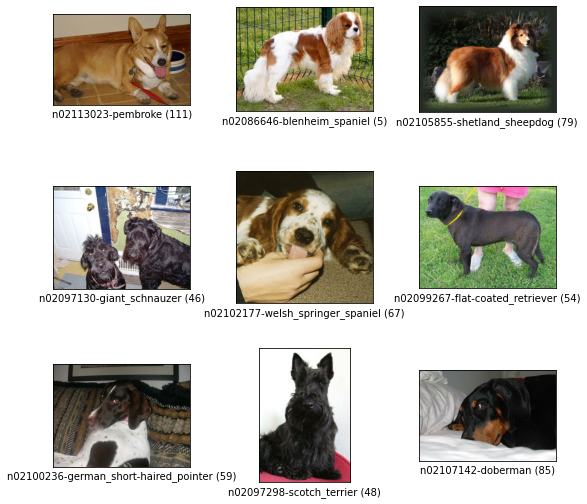

In [5]:
# test 데이터셋 내 이미지 생성
tfds.show_examples(ds_train, ds_info)

### 1-3. Augmentation 적용하기
---

#### 텐서플로우 Random Augmentation API 사용하기

- random_brightness() : (임의의 요소로) 이미지의 밝기 조절
- random_contrast() : (임의의 요소로) 이미지의 대비를 조절
- random_crop() : (임의의 요소로) 이미지의 특정 영역을 기준으로 확대하는 방법
- random_flip_left_right() : (임의의 요소로) 좌우 반전   # flip : 이미지를 대칭하는 기능 
- random_flip_up_down() : (임의의 요소로) 상하 반전
- random_hue() : (임의의 요소로) RGB 이미지의 Hue(색조)를 조절
- random_jpeg_quality() : (임의의 요소로) jpeg_quality를 조절
- random_saturation() : RGB 이미지를 HSV(Hue(색조), Saturation(채도), Value(명도)의 3가지 성분으로 색을 표현) 이미지로 변경하고, S(Saturation) 채널에 오프셋(offset)을 적용해서 조금 더 이미지를 선명하게 만들어 줍니다. 이후 RGB 색상 모델로 변경을 해줍니다.

In [6]:
# 전처리 함수 양식
def 전처리_함수(image, label):   # 변환할 이미지와 라벨
    # 이미지 변환 로직 적용
    new_image = 이미지_변환(image)
    return new_image, label

In [7]:
# Augmentation을 적용하기에 앞서 기본적인 전처리 함수 생성
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`   # 입력받은 이미지를 0~1 사이의 float32로 normalize
    image = tf.image.resize(image, [224, 224])   # (224, 224) 사이즈로 resize
    return tf.cast(image, tf.float32) / 255., label

In [8]:
# augment 전처리 함수 생성
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # flip으로 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2) # max_delta=0.2로 밝기 조절
    image = tf.clip_by_value(image, 0, 1) # 텐서 값을 지정된 최소값 (0) 및 최대값 (1)으로 자릅니다.
    return image, label

In [9]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False): # with_aug=False : augmentation이 적용되지 않음
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)   # tf.data 런타임이 실행 시에 동적으로 값을 조정
    return ds

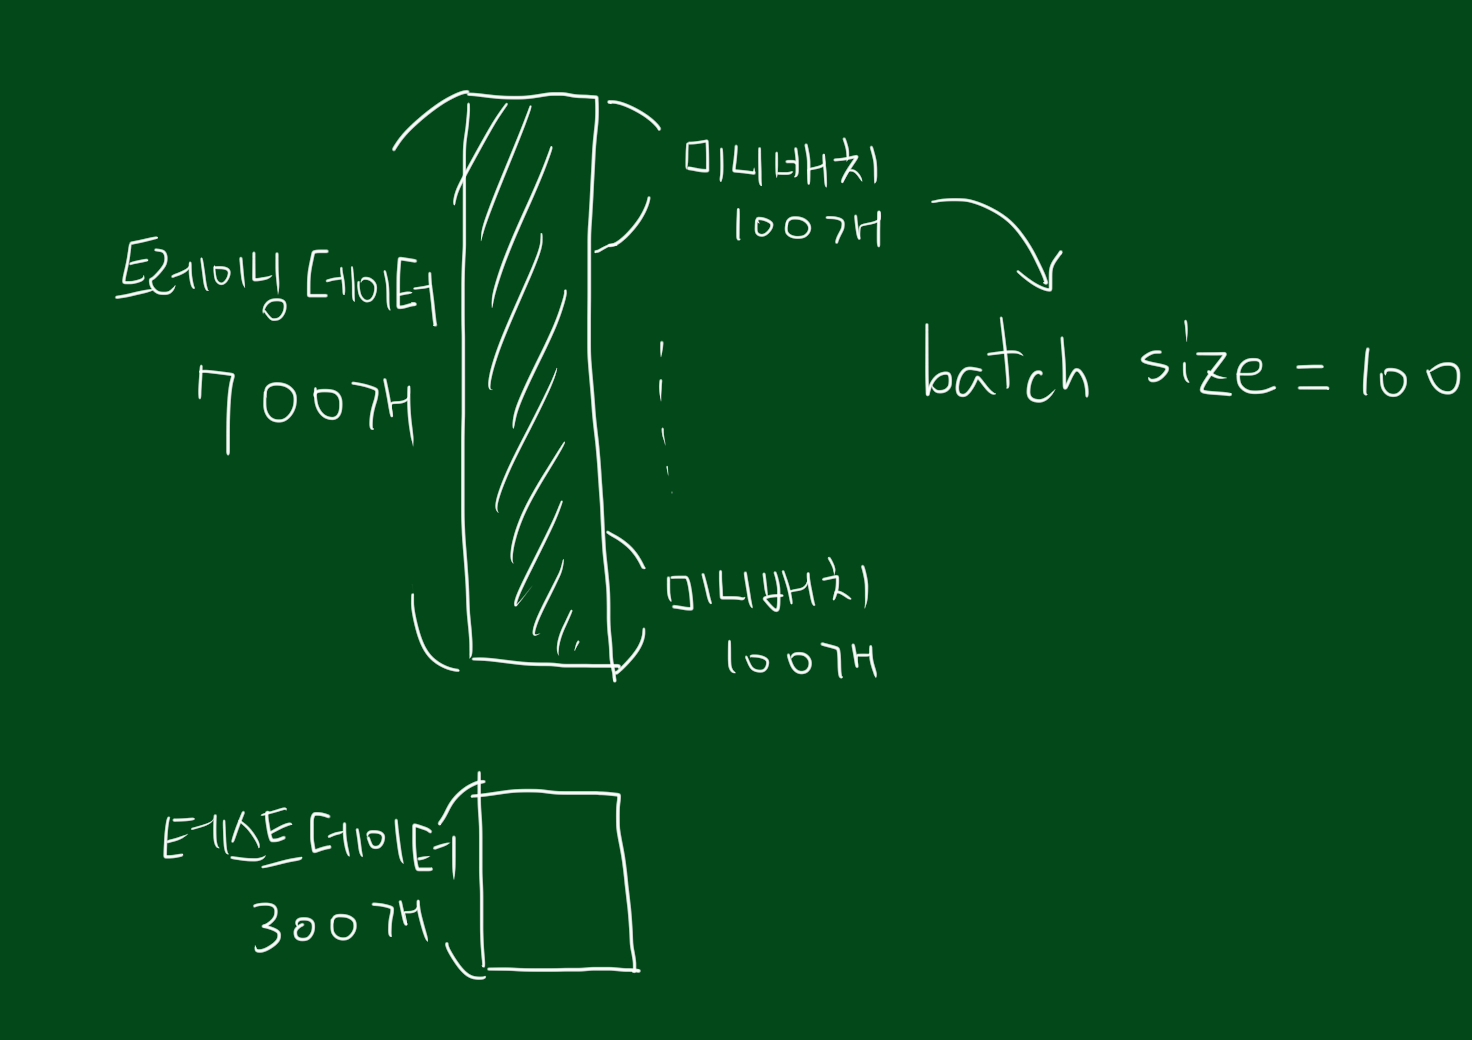

cf) batch_size의 의미

batch_size란 정확히 무엇을 의미할까요?

전체 트레이닝 데이터 셋을 여러 작은 그룹을 나누었을 때 batch size는 하나의 소그룹에 속하는 데이터 수를 의미합니다.

전체 트레이닝 셋을 작게 나누는 이유는 트레이닝 데이터를 통째로 신경망에 넣으면 비효율적이 리소스 사용으로 학습 시간이 오래 걸리기 때문입니다.

- [[딥러닝] 배치 사이즈(batch size) vs 에포크(epoch) vs 반복(iteration)의 차이](https://losskatsu.github.io/machine-learning/epoch-batch/#1-%EC%82%AC%EC%A0%84%EC%A0%81-%EC%9D%98%EB%AF%B8)

그러므로 위의 train set은 총 12,000장 이므로

batch_size = 16 이면

총 12,000장이 있는 train set을 총 750 개의 미니 배치 (batch_size = 16 = 16장의 이미지를 가지고 있음) 로

트레이닝 셋을 작게 나눠준 것이라고 볼 수 있을 것 같습니다.

In [10]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### (4) Cutmix Augmentation 적용
---
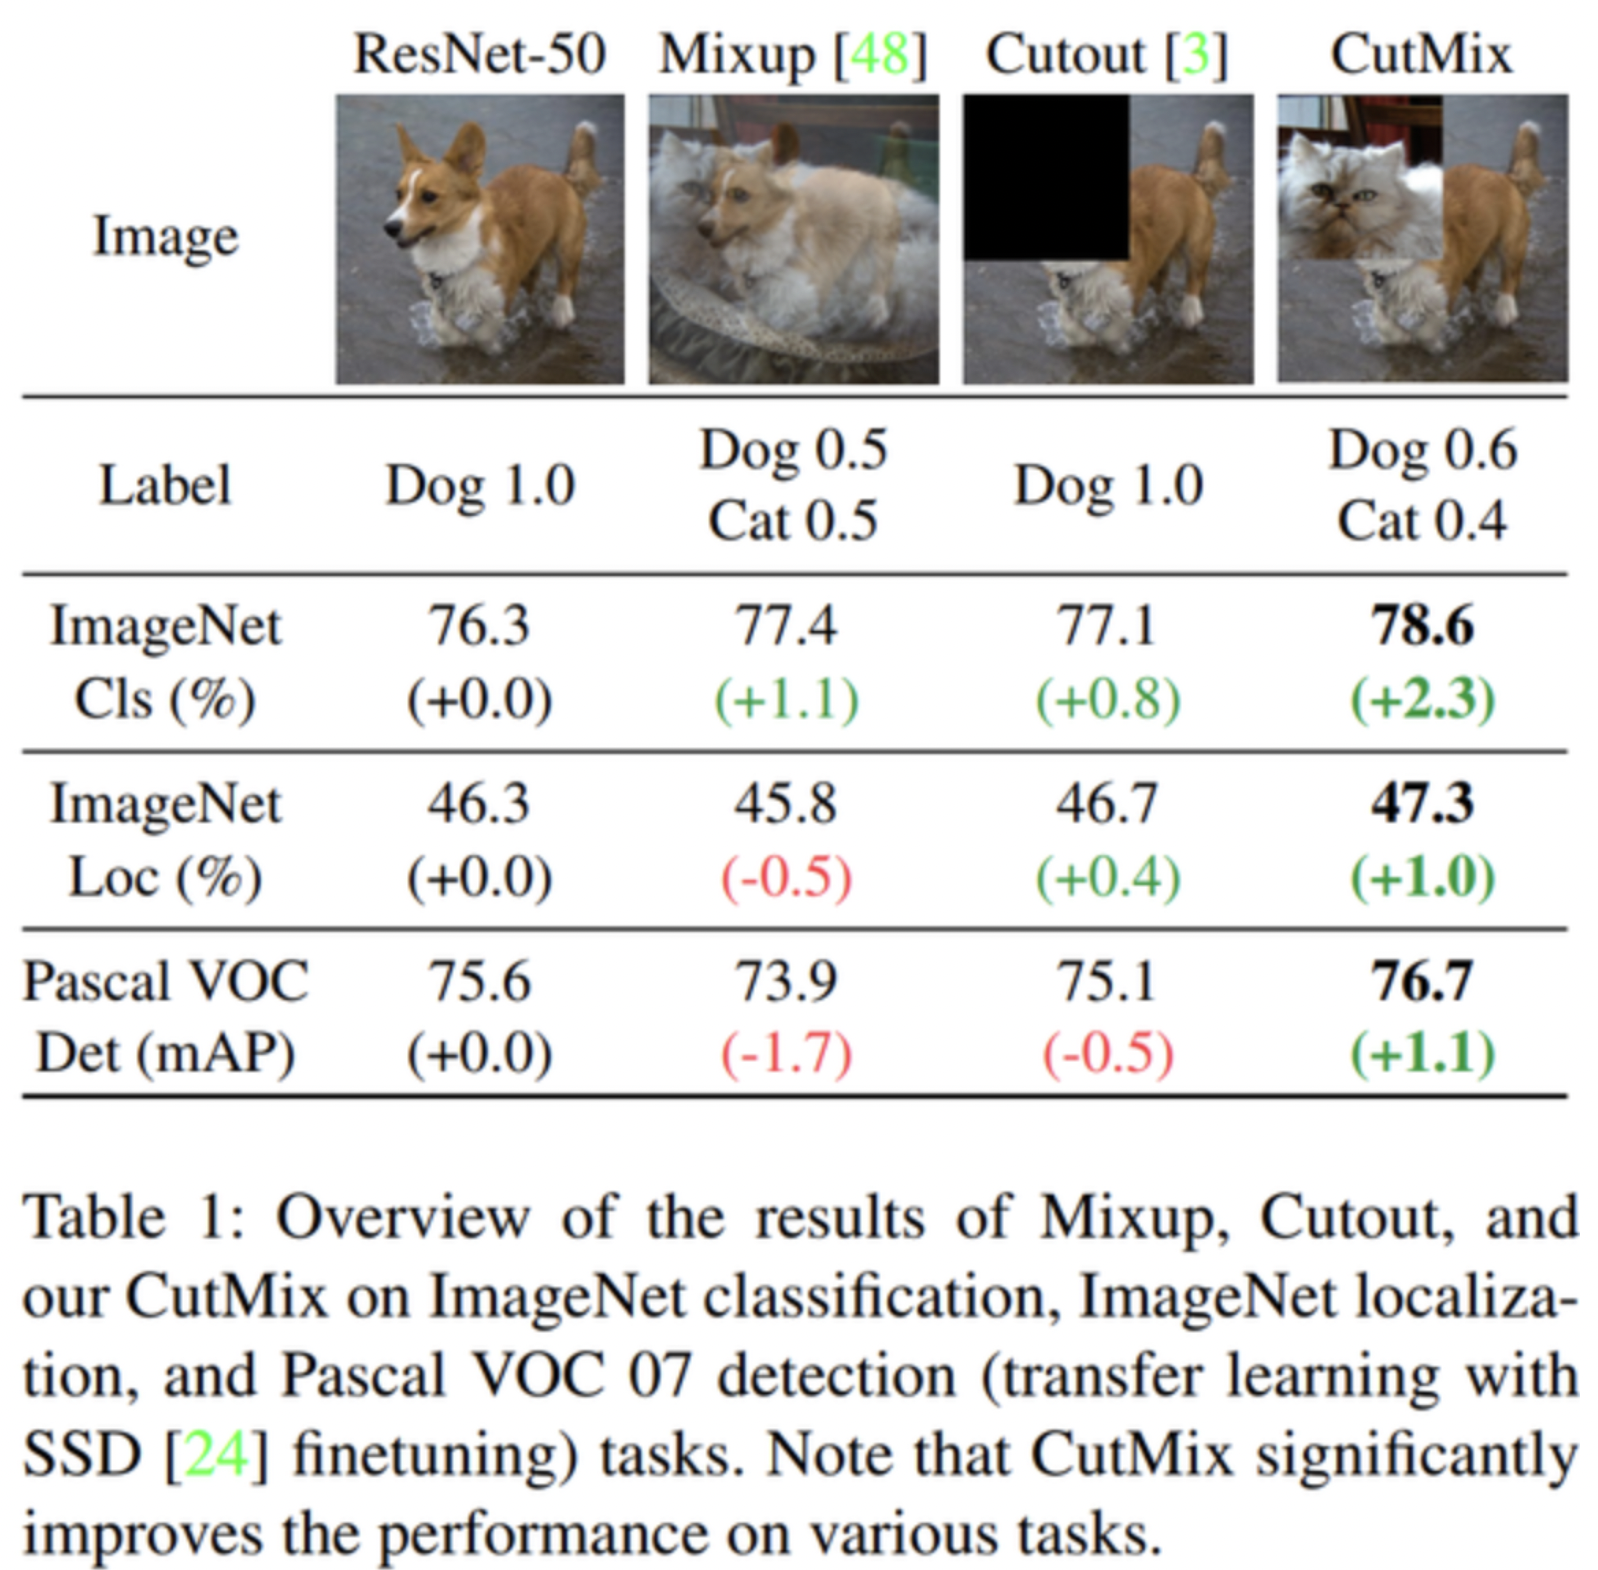

위의 표는 [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf) 본 논문의 저자들이 ImageNet classification 에서 Mixup, Cutout, CutMix의 결과를 보여주며,

ResNet-50 컬럼은 일반적으로 기존에 사용해왔던 방식을 나타내며, 그림을 보면 알 수 있듯이 `Mixup`은 특정 비율로 픽셀별 값을 섞는 방식이고, `Cutout`은 이미지를 잘라내는 방식입니다.

마지막으로 `CutMix` 는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법으로 쉽게 말해서 이미지 데이터를 자르고 섞었다고 보면 됩니다.

`CutMix` 를 진행하기 위해서는 1) 이미지 섞기 & 2) 라벨 섞기의 과정이 필요합니다.

- 배치 내의 이미지를 두 개 고른 후, 바운딩 박스(bounding box, 이미지에서 잘라서 섞어주는 영역)의 위치를 랜덤하게 뽑고 해당 영역을 자른 뒤 2개의 이미지를 섞어준 뒤 라벨도 이에 맞게 섞어주어야 합니다.

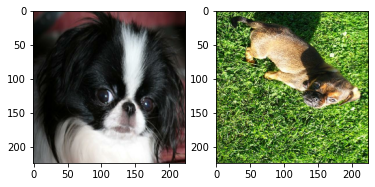

In [11]:
# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

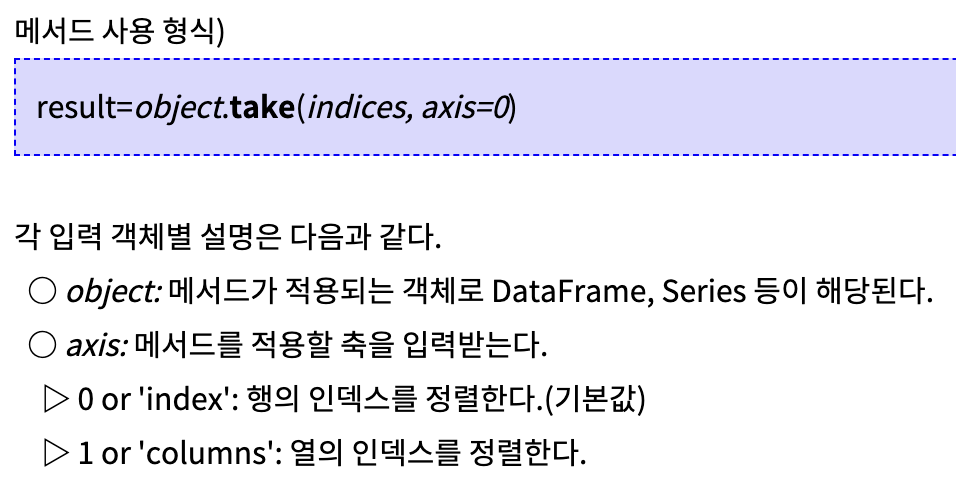

- [데이터의 열의 빠른 추출, take() 메서드](https://kongdols-room.tistory.com/181)

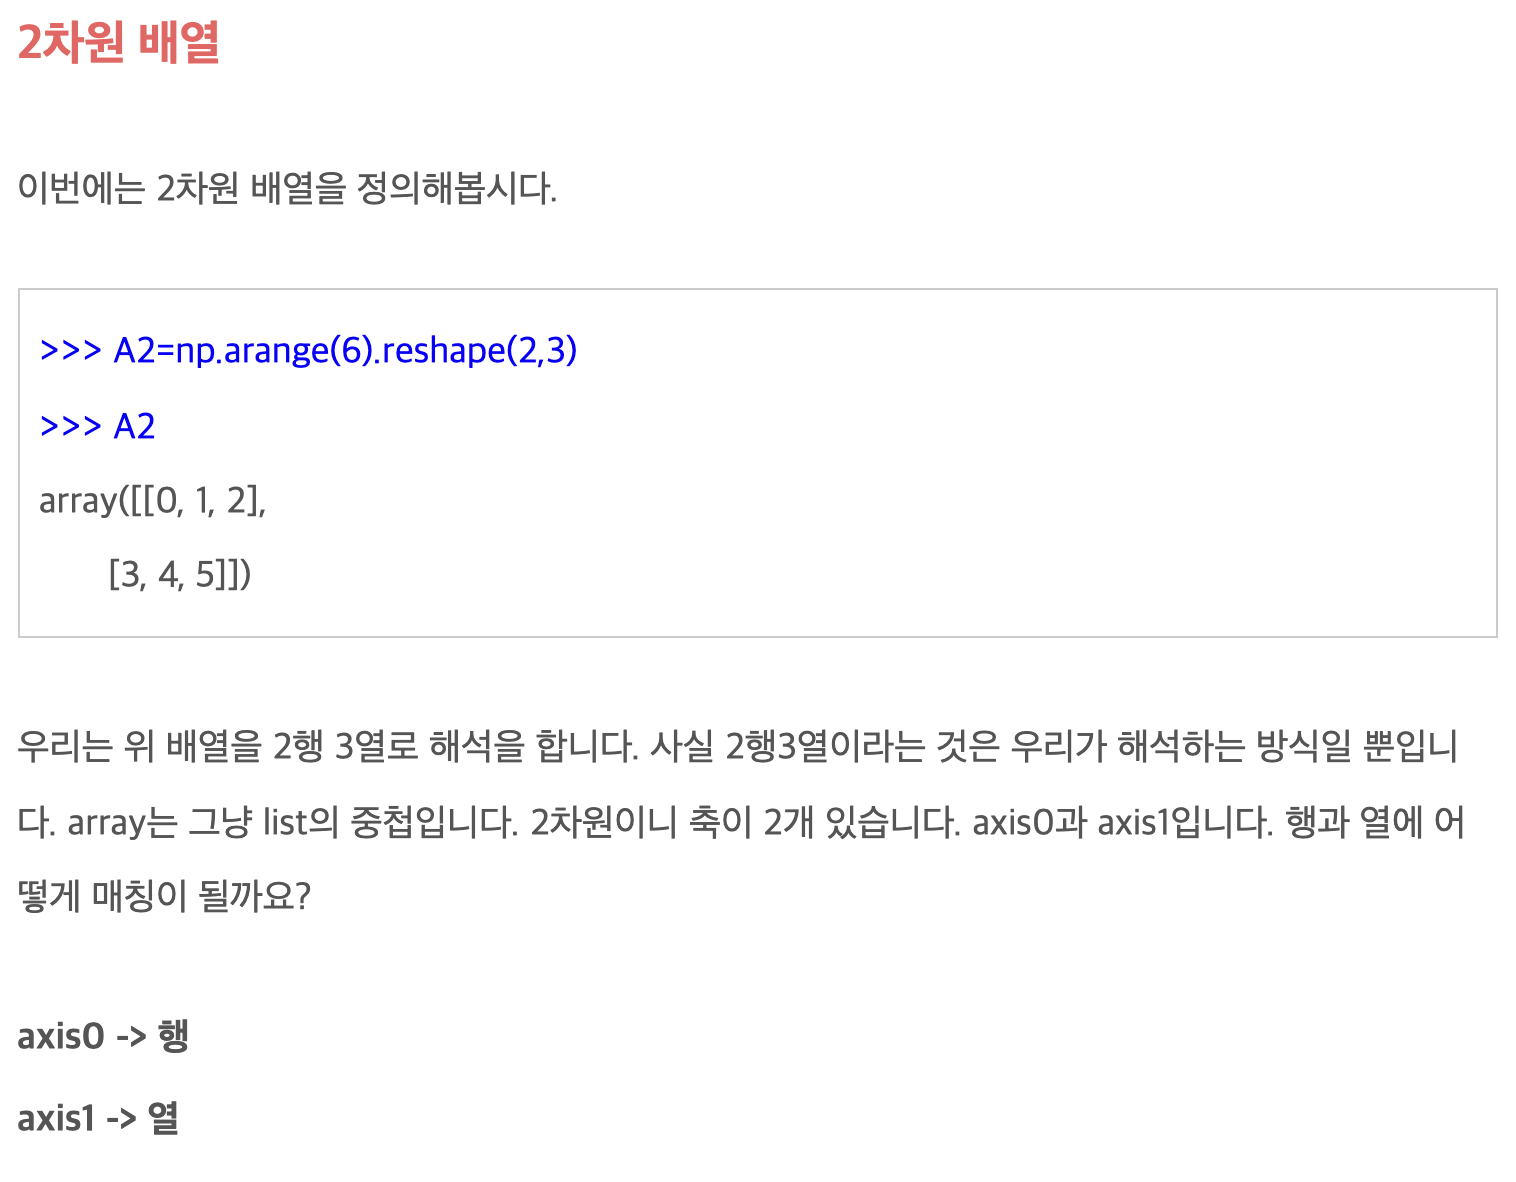

- [배열의 축(axix) 이해하기](https://pybasall.tistory.com/129)

즉, 위 코드에서 ds_train_no_aug.take(1) 은 ds_train_no_aug 내에 있는 행렬의 열을 인덱스로 정리한다는 것을 의미하며,

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break
        
위 코드는 위에서 본 750 개의 미니 배치 (batch_size = 16 = 16장의 이미지를 가지고 있음) 중 하나의 미니 배치를 가져와서 그 안에 있는 임의의 사진 0, 1 가지고 온 것으로 이해했습니다.

In [11]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(91, shape=(), dtype=int32)
y :  tf.Tensor(59, shape=(), dtype=int32) tf.Tensor(200, shape=(), dtype=int32)


### ㄱ. 이미지 섞기
---
바탕이미지 `image_a`에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 `image_b`에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수 구현해 보겠습니다.

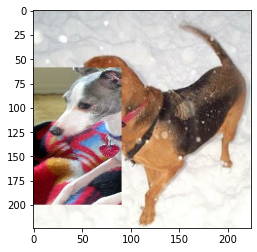

In [12]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### ㄴ. 라벨 섞기
---
CutMix에서는 면적에 비례해서 라벨을 섞어줍니다.

섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해줍니다.

예를 들어 A 클래스를 가진 원래 이미지 `image_a`와 B 클래스를 가진 이미지 `image_b`를 섞을 때 `image_a`를 0.4만큼 섞었을 경우, 0.4만큼의 클래스 A, 0.6만큼의 클래스 B를 가지도록 해줍니다.

이때 라벨 벡터는 보통 클래스를 표시하듯 클래스 1개만 1의 값을 가지는 원-핫 인코딩이 아니라 A와 B 클래스에 해당하는 인덱스에 각각 0.4, 0.6을 배분하는 방식을 사용합니다.

위에서 섞인 이미지 두 가지에 대하여 라벨을 만들 때 적절한 비율로 라벨을 합쳐주는 함수를 구현해 보겠습니다.

In [13]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.7442801 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.25571987, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

#### 위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현해 보겠습니다.

In [14]:
# cutmix() 함수 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120): # prob : cutmix() 가 활성화 될 경우, cutmix()를 수행할 확률
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [15]:
# num_classes 값 확인
num_classes = ds_info.features["label"].num_classes

### 1-5. Mixup Augmentation 적용
---
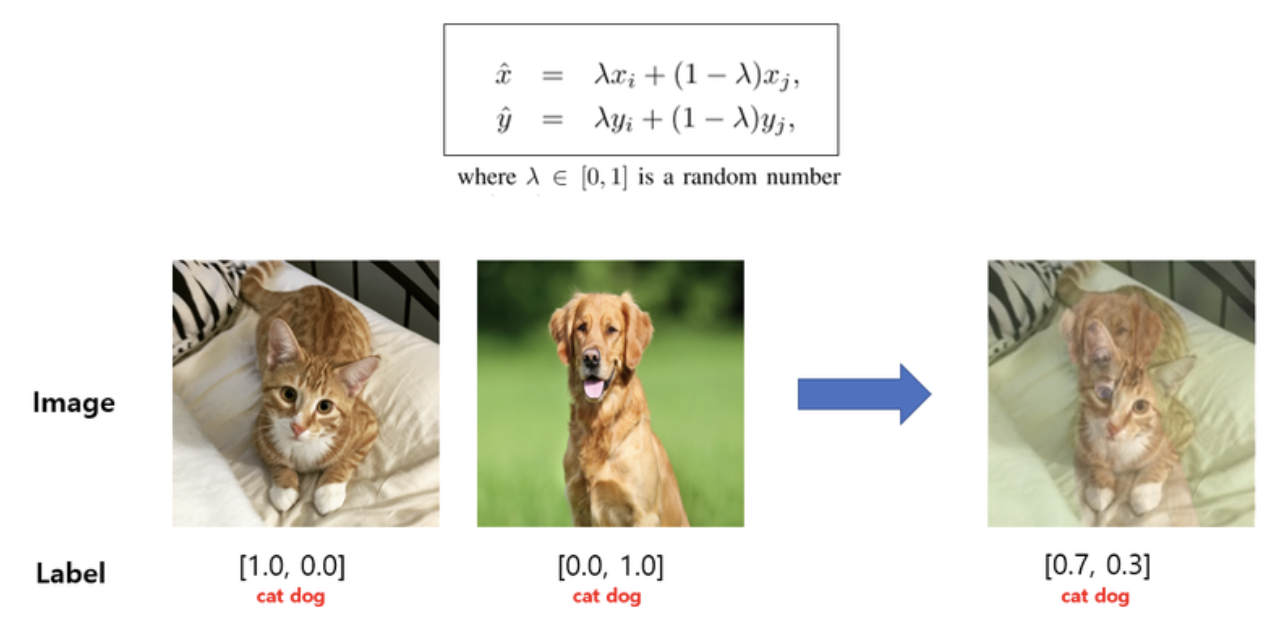

- Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어주는 Augmentation 방식입니다.
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 됩니다.

- 쉽게 말해서, 앞에서 사용한 CutMix 방식은 두 이미지의 일부를 잘라 합치는 방식이었다면, 해당 Mixup 방식은 두 이미지를 자르지 않고 픽셀별로 합치는 방식입니다.

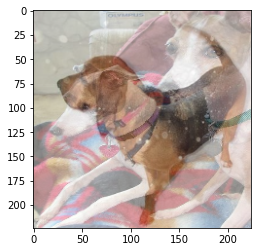

tf.Tensor(
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.5715679 0.
 0.        0.        0.        0.        0.        0.        0.4284321
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0

In [16]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [17]:
# 위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 1-6. onehot 함수
---

In [18]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

### 1-7. 데이터셋 만들기
---

위에서 만든 `CutMix`, `Mixup` Augmentation 이 적용 가능하도록 `apply_normalize_on_dataset` 함수를 수정 해 줍니다.

In [19]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,
                               with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
        
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)


ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)



ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 ResNet-50을 사용한 모델 두 개를 만들어 줍니다.

아래 코드는 텐서플로우 케라스의 `ResNet50` 중 `imagenet`으로 훈련된 모델을 불러옵니다.

`include_top`은 마지막 fully connected layer를 포함할지 여부입니다.

해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다.

이렇게 하는 이유는 이미지넷(ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

### 2-1. ResNet50 중 imagenet으로 훈련된 모델

In [21]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2-2. 기본 Augumentation 적용한 데이터셋으로 학습시킬 ResNet50 모델

In [22]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2-3. CutMix 적용 모델

In [23]:
aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2-4. Mixup 적용 모델

In [24]:
aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 3. 모델 훈련하기
---
모델을 훈련시켜 줍니다.

cf) 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용해 주어야 합니다.

왜냐하면, cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문입니다.

sparse_categorical_crossentropy 는 각 샘플이 오직 하나의 class 에 속할 때 사용하고,
categorical_crossentropy 는 각 샘플이 여러 개의 class 에 속할 수 있거나 label이 soft probablities 일 때 사용하는 것이 좋습니다. (eg. [0.5, 0.3, 0.3])

- [sparse_categorical_crossentropy와 categorical_crossentropy 비교](https://ahnjg.tistory.com/88)

### 3-1. ResNet50 중 imagenet으로 훈련된 모델 훈련

In [25]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 3

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 363s 446ms/step - loss: 3.1891 - accuracy: 0.2855 - val_loss: 3.1364 - val_accuracy: 0.2364
Epoch 2/20
750/750 [==============================] - 335s 447ms/step - loss: 0.9215 - accuracy: 0.7359 - val_loss: 1.4340 - val_accuracy: 0.5979
Epoch 3/20
750/750 [==============================] - 331s 441ms/step - loss: 0.3324 - accuracy: 0.9267 - val_loss: 1.0268 - val_accuracy: 0.6990
Epoch 4/20
750/750 [==============================] - 330s 440ms/step - loss: 0.0958 - accuracy: 0.9886 - val_loss: 0.9121 - val_accuracy: 0.7372
Epoch 5/20
750/750 [==============================] - 332s 442ms/step - loss: 0.0350 - accuracy: 0.9971 - val_loss: 0.9310 - val_accuracy: 0.7386
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0178 - accuracy: 0.9995 - val_loss: 0.9238 - val_accuracy: 0.7436
Epoch 7/20
750/750 [==============================] - 329s 438ms/step - loss: 0.0143 - accuracy: 0.9996 - val_loss: 0.9442 -

### 3-2. 기본 Augumentation 적용한 데이터셋으로 학습시킬 ResNet50 모델 훈련

In [26]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 341s 443ms/step - loss: 3.2127 - accuracy: 0.2730 - val_loss: 2.9179 - val_accuracy: 0.2719
Epoch 2/20
750/750 [==============================] - 328s 437ms/step - loss: 1.0897 - accuracy: 0.6964 - val_loss: 1.1743 - val_accuracy: 0.6531
Epoch 3/20
750/750 [==============================] - 330s 440ms/step - loss: 0.5859 - accuracy: 0.8353 - val_loss: 1.1019 - val_accuracy: 0.6733
Epoch 4/20
750/750 [==============================] - 332s 442ms/step - loss: 0.3139 - accuracy: 0.9225 - val_loss: 0.9982 - val_accuracy: 0.7140
Epoch 5/20
750/750 [==============================] - 330s 440ms/step - loss: 0.1697 - accuracy: 0.9654 - val_loss: 1.0746 - val_accuracy: 0.6969
Epoch 6/20
750/750 [==============================] - 329s 439ms/step - loss: 0.0946 - accuracy: 0.9858 - val_loss: 1.0817 - val_accuracy: 0.6986
Epoch 7/20
750/750 [==============================] - 336s 448ms/step - loss: 0.0825 - accuracy: 0.9885 - val_loss: 1.1016 -

### 3-3. CutMix 적용 모델 훈련

In [27]:
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug_cutmix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 342s 442ms/step - loss: 4.4016 - accuracy: 0.1046 - val_loss: 2.9874 - val_accuracy: 0.2697
Epoch 2/20
750/750 [==============================] - 331s 441ms/step - loss: 3.1377 - accuracy: 0.3785 - val_loss: 1.4491 - val_accuracy: 0.6073
Epoch 3/20
750/750 [==============================] - 336s 448ms/step - loss: 2.8195 - accuracy: 0.4668 - val_loss: 1.3018 - val_accuracy: 0.6341
Epoch 4/20
750/750 [==============================] - 332s 443ms/step - loss: 2.6283 - accuracy: 0.5260 - val_loss: 1.2675 - val_accuracy: 0.6417
Epoch 5/20
750/750 [==============================] - 334s 446ms/step - loss: 2.4929 - accuracy: 0.5741 - val_loss: 1.2920 - val_accuracy: 0.6486
Epoch 6/20
750/750 [==============================] - 335s 447ms/step - loss: 2.3803 - accuracy: 0.6099 - val_loss: 1.2834 - val_accuracy: 0.6510
Epoch 7/20
750/750 [==============================] - 338s 451ms/step - loss: 2.2958 - accuracy: 0.6317 - val_loss: 1.1415 -

### 3-4. Mixup 적용 모델 훈련

In [28]:
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug_mixup, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 347s 449ms/step - loss: 4.2734 - accuracy: 0.1266 - val_loss: 3.5776 - val_accuracy: 0.1763
Epoch 2/20
750/750 [==============================] - 338s 451ms/step - loss: 3.0373 - accuracy: 0.4141 - val_loss: 1.5386 - val_accuracy: 0.5667
Epoch 3/20
750/750 [==============================] - 339s 452ms/step - loss: 2.7450 - accuracy: 0.5181 - val_loss: 1.5162 - val_accuracy: 0.5792
Epoch 4/20
750/750 [==============================] - 335s 447ms/step - loss: 2.5535 - accuracy: 0.5906 - val_loss: 1.2690 - val_accuracy: 0.6423
Epoch 5/20
750/750 [==============================] - 329s 438ms/step - loss: 2.4120 - accuracy: 0.6432 - val_loss: 1.2613 - val_accuracy: 0.6468
Epoch 6/20
750/750 [==============================] - 329s 439ms/step - loss: 2.2998 - accuracy: 0.6851 - val_loss: 1.1737 - val_accuracy: 0.6707
Epoch 7/20
750/750 [==============================] - 334s 445ms/step - loss: 2.2342 - accuracy: 0.7147 - val_loss: 1.3988 -

## 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

### 4-1. Accuracy (val) 시각화

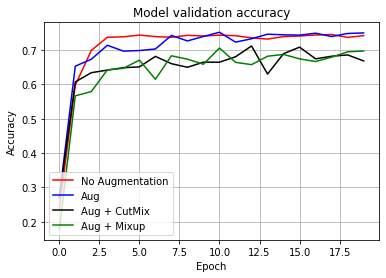

In [30]:
plt.plot(history_resnet50.history['val_accuracy'], 'red')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'blue')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'black')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'green')


plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Aug', 'Aug + CutMix', 'Aug + Mixup'], loc='lower left')

plt.grid(True)
plt.show()

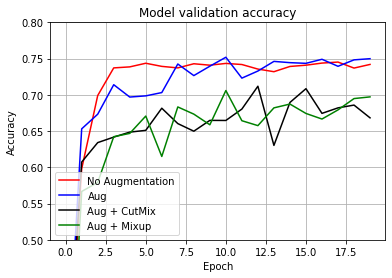

In [43]:
# 조금 더 확대한 시각화
plt.plot(history_resnet50.history['val_accuracy'], 'red')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'blue')

plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'black')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'green')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Aug', 'Aug + CutMix', 'Aug + Mixup'], loc='lower left')

plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
# plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 정리

- 과거 Exploration 노드에서 Augmentation을 해보면서 원본의 정확도가 높다라는 것은 알고 있었지만, 아마도 다른 종과의 Augmentation이 아닌 단일 종 (dog) 을 가지고 Augmentation을 진행해서 그런지 원본과 Augmentation과의 큰 차이가 없다는 것을 알 수 있었습니다.

- 또한, 사람의 눈으로는 CutMix가 이질감이 들기도 하고 다른 종처럼 보이긴 하지만, 모델 학습 결과 CutMix나 Mixup은 val_accuracy 만 보았을 때, 유의미한 차이를 보이지 않음을 확인하였습니다

### 4-2. Loss (val) 시각화

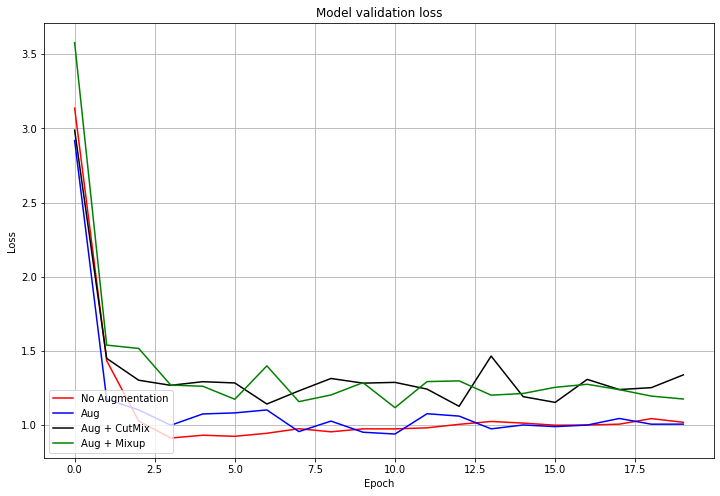

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50.history['val_loss'], 'red')
plt.plot(history_resnet50_aug.history['val_loss'], 'blue')


plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'black')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'green')



plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Aug', 'Aug + CutMix', 'Aug + Mixup'], loc='lower left')

plt.grid(True)
plt.show()

### 정리
- 4가지 모델 모두Epoch 가 2.5 이후로 갈 수록 1.0 ~ 1.5 내외의 val_loss를 보여 주었습니다.

- 물론 위에서 본 결과와 유사하게, CutMix나 Mixup의 val_loss가 원본과 단순 Augmentation 을 한 이미지 보다 더 높은 val_loss 를 가지고 있음을 확인하였습니다.

## 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

### 5-1. Accuracy (val)

In [32]:
import pandas as pd

val_acc_data = {'No Augmentation': history_resnet50.history['val_accuracy'], 
            'Aug': history_resnet50_aug.history['val_accuracy'], 
            'Aug + CutMix': history_resnet50_aug_cutmix.history['val_accuracy'], 
            'Aug + Mixup': history_resnet50_aug_mixup.history['val_accuracy']}

acc_df = pd.DataFrame(val_acc_data)
acc_df

No Augmentation       Aug  Aug + CutMix  Aug + Mixup
0          0.236357  0.271922      0.269706     0.176306
1          0.597948  0.653102      0.607276     0.566698
2          0.699044  0.673274      0.634095     0.579174
3          0.737173  0.713969      0.641674     0.642257
4          0.738573  0.696945      0.648554     0.646805
5          0.743587  0.698577      0.651003     0.670709
6          0.739272  0.703125      0.681553     0.614972
7          0.737173  0.742537      0.660331     0.683302
8          0.742887  0.726562      0.649837     0.673391
9          0.740905  0.739506      0.664762     0.658699
10         0.743354  0.751866      0.664645     0.705923
11         0.741838  0.723064      0.680387     0.664296
12         0.735541  0.732859      0.711870     0.657533
13         0.731926  0.746152      0.630247     0.682020
14         0.739156  0.744403      0.689482     0.687267
15         0.740905  0.743470      0.708489     0.674324
16         0.743820  0.749067      0.674440     0.666628
17         0.745219  0.739389      0.682020     0.679221
18         0.736940  0.748251      0.685868     0.694846
19         0.741954  0.749883      0.668260     0.697178

In [33]:
acc_mean = acc_df.mean()
acc_mean

No Augmentation    0.705679
Aug                0.702396
Aug + CutMix       0.645225
Aug + Mixup        0.636077
dtype: float64

### 정리

원본 > 기본 Aug > CutMix > Mixup 순으로 val_Accuracy 값이 높다는 것을 확인하였습니다.

### 5-2. Loss (val)

In [40]:
val_loss_data = {'No Augmentation': history_resnet50.history['val_loss'], 
            'Augmentation': history_resnet50_aug.history['val_loss'], 
            'CutMix': history_resnet50_aug_cutmix.history['val_loss'], 
            'Mixup': history_resnet50_aug_mixup.history['val_loss']}
loss_df = pd.DataFrame(val_loss_data)
loss_df

No Augmentation  Augmentation    CutMix     Mixup
0          3.136447      2.917878  2.987426  3.577588
1          1.433954      1.174279  1.449130  1.538581
2          1.026763      1.101935  1.301845  1.516192
3          0.912140      0.998219  1.267503  1.269047
4          0.931048      1.074578  1.292020  1.261335
5          0.923814      1.081679  1.283445  1.173692
6          0.944249      1.101568  1.141507  1.398808
7          0.974878      0.955700  1.230157  1.157503
8          0.954128      1.026311  1.313684  1.202546
9          0.973887      0.951286  1.282362  1.285395
10         0.973923      0.939168  1.287347  1.116876
11         0.980946      1.076046  1.242003  1.292651
12         1.004508      1.060038  1.126017  1.297499
13         1.023759      0.974082  1.464620  1.201115
14         1.012835      1.000164  1.191175  1.212568
15         0.998518      0.989104  1.152406  1.254175
16         0.999952      0.999411  1.307497  1.274448
17         1.005640      1.044046  1.238957  1.238300
18         1.043141      1.005438  1.251792  1.194977
19         1.018090      1.005827  1.338042  1.175118

In [41]:
loss_mean = loss_df.mean()
loss_mean

No Augmentation    1.113631
Augmentation       1.123838
CutMix             1.357447
Mixup              1.381921
dtype: float64

### 정리

원본 > 기본 Aug > CutMix > Mixup 순으로 val_loss 값이 낮다는 것을 확인하였습니다.

## 6. 루브릭 & 회고 & Reference
---

### 루브릭
---

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.

2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

- Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함

3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

### 회고
---
과거 Exploration 에서 Augmentaion 다룬 경험이 있어서 '아무리 Data Augmentaion를 하더라도 원본만 못하다.' 라는 것을 본인은 알고 있었기 때문에, 원본과 Augmentaion 사이의 Accuracy 나 loss 값에서 유의미한 차이가 있을 것으로 판단하였습니다.

하지만, 실제로 모델을 학습 후 결과를 확인해본 결과 생각보다 원본과 Augmentaion 과의 차이에서 유의미한 차이가 없음을 확인 할 수 있었습니다.

이것은 본인의 생각이지만, 아마도 다른 종과의 Augmentation이 아닌 단일 종 (dog) 을 가지고 Augmentation을 진행하여 학습 후 테스트를 진행해서 결과적으로 Accuracy 나 loss 값에서 유의미한 차이가 없지 않았나? 라고 생각을 했습니다.

물론 이 접근이 맞는 접근인지는 모르겠으나 본인은 딥러닝 모델의 학습 과정에서 augmentation을 왜 사용하는가? 라는 걸 초점으로 생각했을 때,

모델을 생성하고 학습 과정에서 원본 이미지로 모델을 학습 시키는 것이 모델의 성능을 올리는 것에 중요하다! 라고 있습니다.

하지만 위와 같이 진행하기엔 데이터 수집과정에서의 한계와 데이터 수가 적을 시에 발생할 수 있는 과적합의 문제를 해결하기 위한 방법으로 데이터 증강을 하기 위해서 augmentation 을 통한 데이터 확보를 하는 것으로 알고 있습니다.

그렇다면, augmentation 후 나오는 모델의 학습 결과를 비교하기 위해선 원본, 기본 augmentation, CutMix, Mixup 에 따른 모델 학습 후의 테스트 결과가 어떻게 나와야 하는지 알아야 하지 않을까? 라고 생각하면서 진행한 힘겨운 프로젝트였다고 결론을 내릴 수 있을 거 같습니다.

번외1)

개인적으로 이번 프로젝트는 진행하기가 너무 힘들었던 거 같습니다.

왜냐하면, 노드 내에서 적혀 있는 코드로 프로젝트를 진행하는 과정에서 수 없이 많은 오류가 나왔기 때문입니다.

왠만하면 다른 분이 작성하신 코드를 복사 붙여넣기를 하지 않고 진행을 하고싶었는데, 변수 값에서 너무 많은 오류가 발생하면서

주어진 시간으론 프로젝트 마감일을 지킬 수 없을 것으로 판단하여 다른 분이 작성하신 코드를를 참고해서 프로젝트를 마감할 수 있었습니다.

또한, Epoch = 20 에 모델 1개를 학습 하는데 약 2시간 정도가 소요 되는 상태를 겪어보며 해커톤 과정 중 모델 학습을 어떻게 하면 효율적으로 하고 좋은 그래픽카드를 어떻게 확보 할 수 있을까? 라는 생각을 하게 해주는 노드였습니다.

진심으로 OOM(메모리 이슈) 나 인터넷 이슈로 모델 중간에 끊겼을 때, 진심으로 화가 나는 일이 생겼었는데,

이 문제는 김성연님의 조언에 따라 앞으로는 모델 학습 과정에서 .json 파일 내에 학습에 대한 데이터를 기록하는 과정을 통해서 해결해 보려고 합니다.

번외2)

또한, 본인은 다른 분이 작성하신 코드를 참고하는 과정에서 단순히 코드를 이렇게 작성할 경우 어떤 결과가 나오니 이 코드는 이런 의미이구나?

라고 귀납적으로 학습을 하는 경향이 있습니다. 각 코드의 의미를 하나하나 알아보지 않았다는 뜻이지요.

하지만, 프로젝트 제출 후 스터디원들과의 대화를 통해서 본인의 학습 방법이 잘 못 된 것인 거 같다라는 생각을 하는 계기가 되었습니다.

안가영님처럼 각 코드의 의미를 정확하게 알고 코드를 실행 시켜야 하며, 시간이 걸리더라도 하나하나 정확하게 알아가는 과정도 필요하고

조해창님처럼 블로그에 있는 코드는 본인이 이해 할 수 있는 코드로 변경 후, 다양한 방법으로 실행을 해가며 학습을 하는 것이 진짜 학습이구나!

라는 생각을 하며, 시간이 걸리더라도 정확하게 하나하나 알아보는 시간을 갖자는 생각을 남긴 프로젝트였다고 생각합니다.


### Reference
---
- [CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features](https://arxiv.org/pdf/1905.04899.pdf)
- [mixup: BEYOND EMPIRICAL RISK MINIMIZATION](https://arxiv.org/pdf/1710.09412.pdf)
- [Cutmix 논문 이해를 위해 참고한 영상](https://youtu.be/INEaSakYb-U)
- [mixup 논문 이해를 위해 참고한 블로그](https://everyday-image-processing.tistory.com/145)
- [[딥러닝] 배치 사이즈(batch size) vs 에포크(epoch) vs 반복(iteration)의 차이](https://losskatsu.github.io/machine-learning/epoch-batch/#1-%EC%82%AC%EC%A0%84%EC%A0%81-%EC%9D%98%EB%AF%B8)
- [데이터의 열의 빠른 추출, take() 메서드](https://kongdols-room.tistory.com/181)
- [배열의 축(axix) 이해하기](https://pybasall.tistory.com/129)
- [sparse_categorical_crossentropy와 categorical_crossentropy 비교](https://ahnjg.tistory.com/88)
- [프로젝트 진행에 코드를 참고한 노트북 1](https://github.com/yeonkkk/AIFFEL-Project/blob/main/GoingDeeper02/%5BGD2%5Daugmentation.ipynb)
- [프로젝트 진행에 코드를 참고한 노트북 2](https://github.com/oddhyeon/Aiffel/blob/master/GoingDeeper/2.Augmentation_cutmix_mixup/2.Augmentation_cutmix_mixup.ipynb)
- [프로젝트 진행에 코드를 참고한 노트북 3](https://github.com/qsdcfd/AIFFEL/blob/TIL/Personal-Project/Going%20Deeper%20(CV)/Going%20Deeper%2002/%5BGD-04%5DData%20Augmentation%20Sehyun.ipynb)